# Imports

In [14]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


# Variables

In [15]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)
SEED = 42

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

# Setup Dataset

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


# View Some Images

In [17]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# AutoTune Dataset

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [19]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.GaussianNoise(0.2),
    ]
)

## View Augmented Images

2024-10-19 11:45:57.664395: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


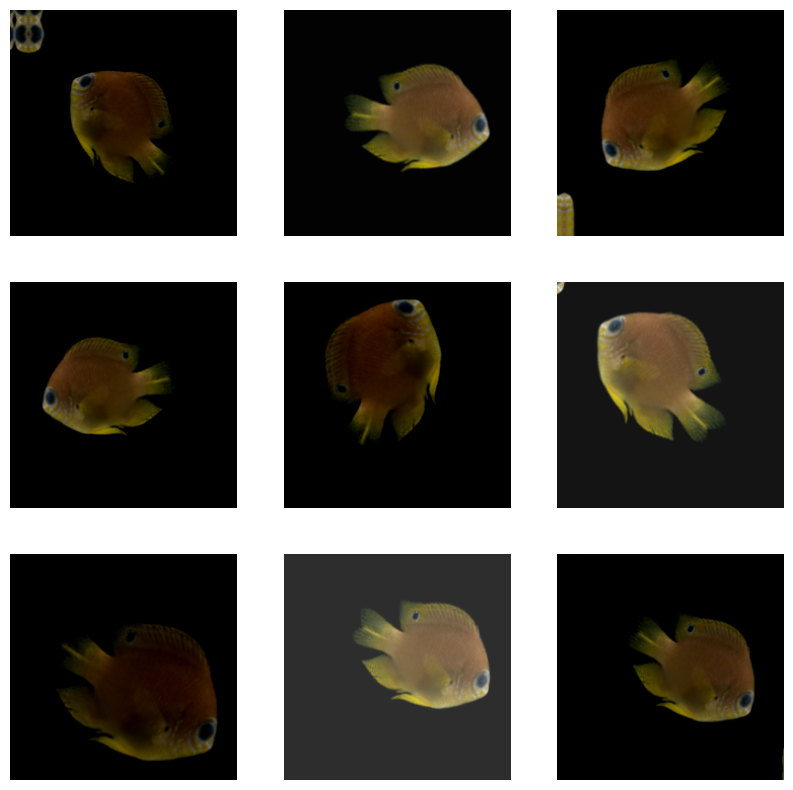

In [20]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [21]:
# MobileNetV2 Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Create Base Model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [22]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [23]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(57, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │       116,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,681,593 (90.34 MB)

 Trainable params: 116,793 (456.22 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [24]:
base_learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [25]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.0054 - loss: 4.9406
initial loss: 4.93
initial accuracy: 0.01


In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - accuracy: 0.0552 - loss: 4.3581 - val_accuracy: 0.2901 - val_loss: 2.9320
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.2785 - loss: 2.9278 - val_accuracy: 0.4717 - val_loss: 2.1482
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.4411 - loss: 2.2033 - val_accuracy: 0.5925 - val_loss: 1.7233
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5372 - loss: 1.7997 - val_accuracy: 0.6478 - val_loss: 1.4646
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.6064 - loss: 1.5579 - val_accuracy: 0.6878 - val_loss: 1.2907
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.6434 - loss: 1.3781 - val_accuracy: 0.7182 - val_loss: 1.1696
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.6729 - loss: 1.2501 - val_accuracy: 0.7341 - val_loss: 1.0820
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.7043 - loss: 1

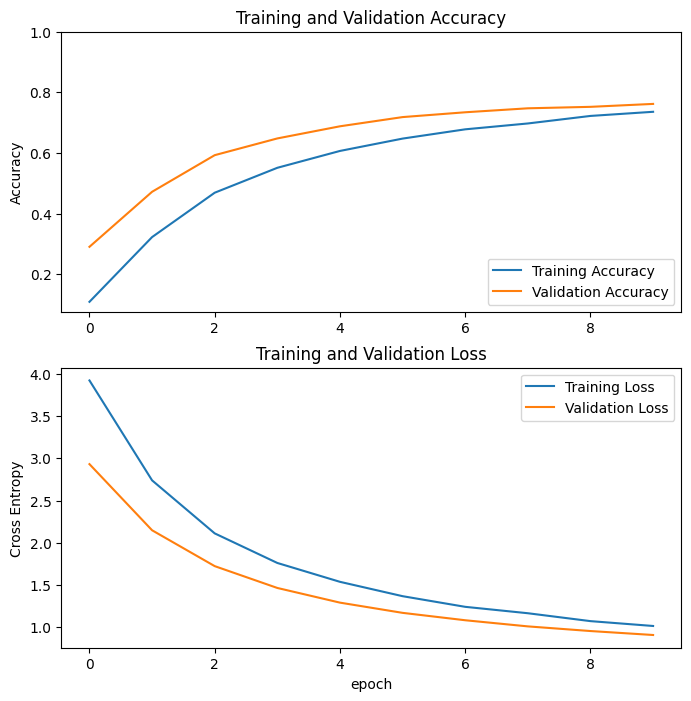

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [28]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [29]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [30]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 64s 309ms/step - accuracy: 0.6853 - loss: 1.3798 - val_accuracy: 0.7914 - val_loss: 0.7900
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7674 - loss: 0.9316 - val_accuracy: 0.8177 - val_loss: 0.6973
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 293ms/step - accuracy: 0.8044 - loss: 0.7680 - val_accuracy: 0.8377 - val_loss: 0.6282
Epoch 14/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.8338 - loss: 0.6569 - val_accuracy: 0.8522 - val_loss: 0.5626
Epoch 15/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step - accuracy: 0.8425 - loss: 0.5829 - val_accuracy: 0.8591 - val_loss: 0.5190
Epoch 16/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.8756 - loss: 0.5025 - val_accuracy: 0.8736 - val_loss: 0.4783
Epoch 17/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 295ms/step - accuracy: 0.8769 - loss: 0.4582 - val_accuracy: 0.8798 - val_loss: 0.4531
Epoch 18/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 292ms/step - accuracy: 0.8915 -

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

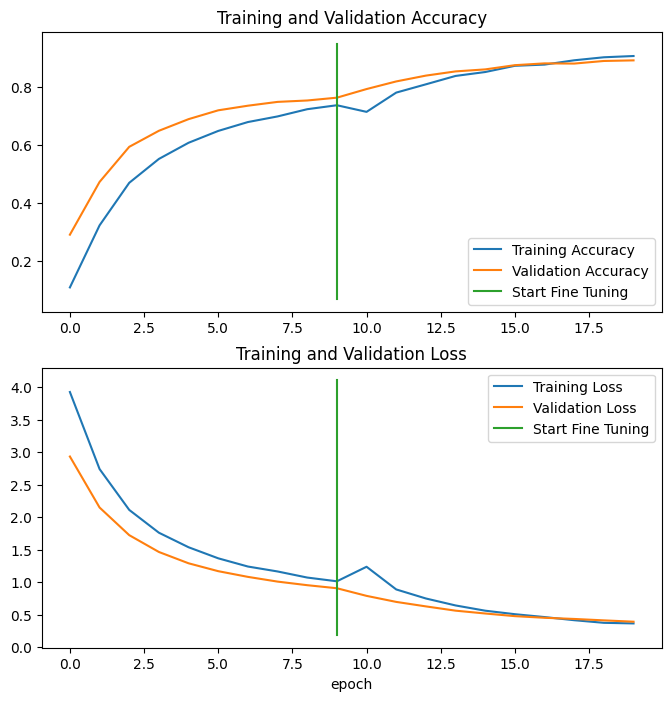

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.8890 - loss: 0.4340
Test accuracy : 0.9060773253440857


In [34]:
model.save('CV_RES50V2_S90608_011924_1204.keras')